Download historical data from EIA and NOAA/GHCN-d to the local filesystem

In [3]:
import download_historical_data as dl
import os 

HISTORICAL_DATA_DIR = os.path.abspath("./historical_data")
ELECTRIC_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "electric_data")
WEATHER_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "weather_station_data")
WEATHER_STATION_IDS = [
    "USW00023066",  # Grand Junction Walker Field
    "USC00053553",  # Greeley UNC
    "USC00053005",  # Ft Collins
    "USC00050848",  # Boulder
    "USC00055984",  # Northglenn
    "USC00058995",  # Wheat Ridge
    "USW00023061"  # Alamosa
]
#dl.download_eia_historical_data(ELECTRIC_DATA_DIR, eia_respondent="PSCO")
#dl.download_ghcnd_historical_data(WEATHER_DATA_DIR, WEATHER_STATION_IDS)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

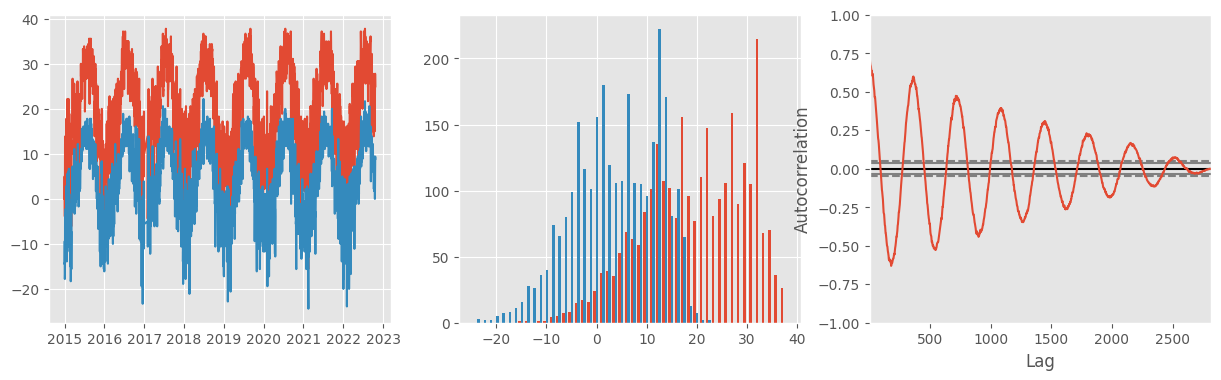

In [10]:
import matplotlib.pyplot as plt
import os
import pandas as pd

plt.style.use("ggplot")
path = os.path.join(WEATHER_DATA_DIR, "USC00050848-dataframe.json")
with open(path, "r", encoding="utf-8") as f:
    temp_df = pd.read_json(f)

# temp_df[["tmax_decimal", "tmin_decimal"]].plot.hist(bins=50, alpha=0.5)
# temp_df.plot(y=["tmax_decimal", "tmin_decimal"])

slice = temp_df[["tmax_decimal", "tmin_decimal"]]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)
ax1.plot(slice)
ax2.hist(slice, bins=50)
pd.plotting.autocorrelation_plot(temp_df["tmax_decimal"])


Load electric demand data

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

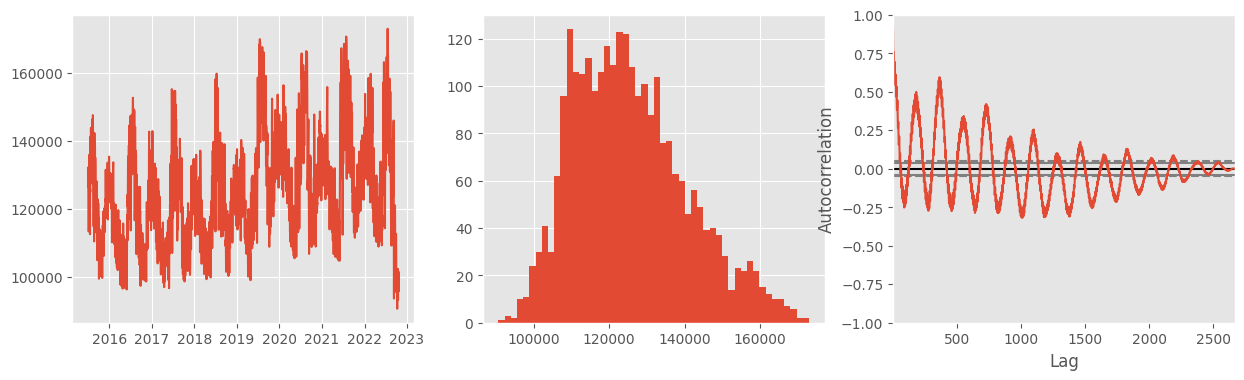

In [11]:
psco_demand_data_file = os.path.join(ELECTRIC_DATA_DIR, "psco-daily-dataframe.json")
with open(psco_demand_data_file, "r", encoding="utf-8") as f:
    demand_df = pd.read_json(f)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)
ax1.plot(demand_df)
ax2.hist(demand_df, bins=50)
pd.plotting.autocorrelation_plot(demand_df)

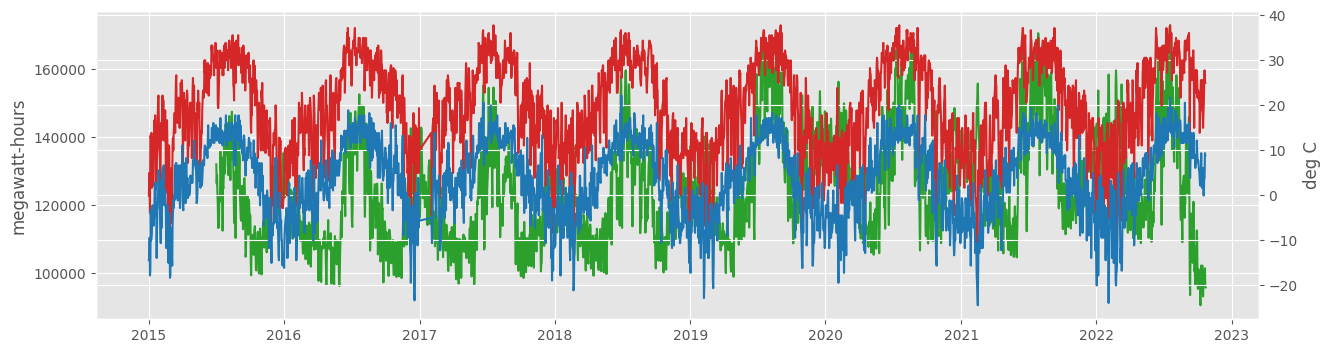

In [19]:
joined_df = pd.concat([demand_df, temp_df])

slice = joined_df[["daily_demand", "tmax_decimal", "tmin_decimal"]]

fig, ax1 = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(4)
ax1.set_ylabel("megawatt-hours")
ax1.plot(joined_df["daily_demand"], color="tab:green")

ax2 = ax1.twinx()
ax2.set_ylabel("deg C")
ax2.plot(joined_df["tmax_decimal"], color="tab:red")
ax2.plot(joined_df["tmin_decimal"], color="tab:blue")